# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import Counter

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.cm as cm
import itertools

In [3]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
CHANNEL_MAPPING_DF = pd.read_excel("channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/trial_metadata.pkl")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("./video_to_frame_and_subject.xlsx")
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/proc/id_corrected"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
VELOCITY_WINDOW_SIZE = FRAME_RATE
ROLLING_AVERAGE_WINDOW_SIZE = FRAME_RATE // 2
TRIAL_DURATION = 10

In [5]:
SPIKEGADGETS_SAMPLE_RATE = 20000
LFP_SAMPLE_RATE = 1000
VELOCITY_BINS = [5, 10]

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [6]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names


In [7]:
def get_sleap_tracks_from_h5(filename):
    """
    Retrieve pose tracking data (tracks) from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    np.ndarray
        A transposed version of the 'tracks' dataset in the provided h5 file.
        
    Example:
    --------
    df['tracks'] = df['filename_column'].apply(get_sleap_tracks_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return f["tracks"][:].T

In [8]:
def get_sleap_track_names_from_h5(filename):
    """
    Retrieve the names of tracked features from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    h5py.Dataset
        The 'track_names' dataset in the provided h5 file, representing the names of the tracked features.
        
    Example:
    --------
    df['track_names'] = df['filename_column'].apply(get_sleap_track_names_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return [item.tobytes().decode('utf-8') for item in f["track_names"][:]]


In [9]:
def get_node_names_from_sleap(filename):
    """
    Retrieve node names from a SLEAP h5 file.

    Parameters:
    - filename (str): Path to the SLEAP h5 file.

    Returns:
    - list of str: List of node names.
    """
    with h5py.File(filename, "r") as f:
        return [n.decode() for n in f["node_names"][:]]

In [10]:

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [11]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [12]:
def extract_sleap_data(filename):
    """
    Extracts coordinates, names of body parts, and track names from a SLEAP file.
    
    Parameters:
    - filename (str): Path to the SLEAP file.
    
    Returns:
    - tuple: A tuple containing the following elements:
        * locations (numpy.ndarray): Array containing the coordinates.
        * node_names (list of str): List of body part names.
        * track_names (list of str): List of track names.
    
    Example:
    >>> locations, node_names, track_names = extract_sleap_data("path/to/sleap/file.h5")
    """
    result = {}
    with h5py.File(filename, "r") as f:
        result["locations"] = f["tracks"][:].T
        result["node_names"] = [n.decode() for n in f["node_names"][:]]
        result["track_names"] = [n.decode() for n in f["track_names"][:]]

    return result

In [13]:
def rescale_dimension_in_array(arr, dimension=0, ratio=1):
    """
    Rescale values of a specified dimension in a 3D numpy array for the entire array.
    
    Parameters:
    - arr (numpy.ndarray): A 3D numpy array where the third dimension is being rescaled.
    - dimension (int, default=0): Specifies which dimension (0 or 1) of the third 
                                  dimension in the array should be rescaled. 
                                  For instance, in many contexts:
                                  0 represents the x-coordinate, 
                                  1 represents the y-coordinate.
    - ratio (float, default=1): The scaling factor to be applied.
    
    Returns:
    - numpy.ndarray: The rescaled array.
    """
    
    arr[:,:,dimension] *= ratio
    return arr

In [14]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [15]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

# Reading in the h5 files between recordings

In [16]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.dropna(subset="start_frame")

In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj
1,/scratch/back_up/reward_competition_extention/...,41000.0,79051.0,1.1,1.1_1.2
2,/scratch/back_up/reward_competition_extention/...,0.0,39500.0,1.1_1.2,1.1_1.2
3,/scratch/back_up/reward_competition_extention/...,0.0,38957.0,1.2,1.1_1.2
4,/scratch/back_up/reward_competition_extention/...,32792.0,68495.0,1.4,1.1_1.4
5,/scratch/back_up/reward_competition_extention/...,0.0,32316.0,1.1_1.4,1.1_1.4


In [18]:
# We will be indexing for the frames, so they must be integers and not floats
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"].astype(int)
VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"].astype(int)

In [19]:
# Getting the basename of the file which corresponds to the ephys recording that the h5 file came from
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: os.path.basename(x).split(".")[0])

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: extract_sleap_data(x))


In [21]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [23]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

1                                                 [1.1]
2     [1.1, 1.2, track_862, track_863, track_1067, t...
3                                                 [1.2]
4                                                 [1.4]
5     [1.1, 1.4, track_867, track_868, track_869, tr...
6                                                 [1.1]
8                                                 [1.2]
9     [1.2, 1.4, track_694, track_695, track_698, tr...
10                                                [1.4]
12                                                [1.2]
13    [1.1, 1.2, track_16, track_18, track_40, track...
14                                                [1.1]
16                                                [1.4]
17    [1.2, 1.4, track_711, track_712, track_713, tr...
18                                                [1.2]
Name: track_names, dtype: object

In [24]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_track_names_from_h5(x))

In [25]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(79051, 6, 2, 1)

In [26]:
# Making sure all the subject IDs are strings instead of floating point numbers
VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"].astype(str)

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

1                                                 [1.1]
2     [1.1, 1.2, track_862, track_863, track_1067, t...
3                                                 [1.2]
4                                                 [1.4]
5     [1.1, 1.4, track_867, track_868, track_869, tr...
6                                                 [1.1]
8                                                 [1.2]
9     [1.2, 1.4, track_694, track_695, track_698, tr...
10                                                [1.4]
12                                                [1.2]
13    [1.1, 1.2, track_16, track_18, track_40, track...
14                                                [1.1]
16                                                [1.4]
17    [1.2, 1.4, track_711, track_712, track_713, tr...
18                                                [1.2]
Name: track_names, dtype: object

In [28]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["individual_subj"].split("_")}, axis=1)

In [29]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

1               {'1.1': 0}
2     {'1.1': 0, '1.2': 1}
3               {'1.2': 0}
4               {'1.4': 0}
5     {'1.1': 0, '1.4': 1}
6               {'1.1': 0}
8               {'1.2': 0}
9     {'1.2': 0, '1.4': 1}
10              {'1.4': 0}
12              {'1.2': 0}
13    {'1.1': 0, '1.2': 1}
14              {'1.1': 0}
16              {'1.4': 0}
17    {'1.2': 0, '1.4': 1}
18              {'1.2': 0}
Name: subject_to_index, dtype: object

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [31]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

1               {'1.1': 0}
2     {'1.1': 0, '1.2': 1}
3               {'1.2': 0}
4               {'1.4': 0}
5     {'1.1': 0, '1.4': 1}
6               {'1.1': 0}
8               {'1.2': 0}
9     {'1.2': 0, '1.4': 1}
10              {'1.4': 0}
12              {'1.2': 0}
13    {'1.1': 0, '1.2': 1}
14              {'1.1': 0}
16              {'1.4': 0}
17    {'1.2': 0, '1.4': 1}
18              {'1.2': 0}
Name: subject_to_tracks, dtype: object

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [33]:
# Convert dictionary items to list of items
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].apply(lambda x: list(x.items()))

In [34]:
# Explode based on the lists
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.explode(["subject_to_tracks"]).reset_index(drop=True)

In [35]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,/scratch/back_up/reward_competition_extention/...,41000,79051,1.1,1.1_1.2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,{'locations': [[[[288.3494873 ] [104.55191803...,"[[[[288.3494873], [104.55191803]], [[304.15475...",[1.1],{'1.1': 0},"(1.1, [[[288.3494873 104.55191803], [304.1547..."
1,/scratch/back_up/reward_competition_extention/...,0,39500,1.1_1.2,1.1_1.2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,{'locations': [[[[416.6953125 288.3494873 ...,[[[[416.6953125 288.3494873 nan ...,"[1.1, 1.2, track_862, track_863, track_1067, t...","{'1.1': 0, '1.2': 1}","(1.1, [[[416.6953125 348.36172485], [432.0613..."
2,/scratch/back_up/reward_competition_extention/...,0,39500,1.1_1.2,1.1_1.2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,{'locations': [[[[416.6953125 288.3494873 ...,[[[[416.6953125 288.3494873 nan ...,"[1.1, 1.2, track_862, track_863, track_1067, t...","{'1.1': 0, '1.2': 1}","(1.2, [[[288.3494873 104.55191803], [304.1547..."
3,/scratch/back_up/reward_competition_extention/...,0,38957,1.2,1.1_1.2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,{'locations': [[[[352.09036255] [407.93740845...,"[[[[352.09036255], [407.93740845]], [[340.0819...",[1.2],{'1.2': 0},"(1.2, [[[352.09036255 407.93740845], [340.0819..."
4,/scratch/back_up/reward_competition_extention/...,32792,68495,1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574] [388.14276123...,"[[[[340.27038574], [388.14276123]], [[324.3432...",[1.4],{'1.4': 0},"(1.4, [[[340.27038574 388.14276123], [324.3432..."


In [36]:
# Split tuple of (key, value) into separate columns
VIDEO_TO_FRAME_AND_SUBJECT_DF[['subject_id', 'subject_locations']] = pd.DataFrame(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].tolist(), index=VIDEO_TO_FRAME_AND_SUBJECT_DF.index)

In [37]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["subject_to_tracks"])

In [38]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_id"]

0     1.1
1     1.1
2     1.2
3     1.2
4     1.4
5     1.1
6     1.4
7     1.1
8     1.2
9     1.2
10    1.4
11    1.4
12    1.2
13    1.1
14    1.2
15    1.1
16    1.4
17    1.2
18    1.4
19    1.2
Name: subject_id, dtype: object

## Getting the coordinates of the corners

In [39]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.fixed.1_subj.round_1.id_corrected.h5'

In [40]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: "{}.fixed.corner.h5".format(x.split("fixed")[0].strip(".")))

In [41]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.fixed.corner.h5'

In [42]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_node_names_from_sleap(x))

In [43]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0     [box_top_left, box_bottom_left, box_bottom_rig...
1     [box_top_left, box_bottom_left, box_bottom_rig...
2     [box_top_left, box_bottom_left, box_bottom_rig...
3     [box_top_left, box_bottom_left, box_bottom_rig...
4     [box_top_left, box_bottom_right, box_bottom_le...
5     [box_top_left, box_bottom_right, box_bottom_le...
6     [box_top_left, box_bottom_right, box_bottom_le...
7     [box_top_left, box_bottom_right, box_bottom_le...
8     [box_top_left, box_bottom_left, box_bottom_rig...
9     [box_top_left, box_bottom_left, box_bottom_rig...
10    [box_top_left, box_bottom_left, box_bottom_rig...
11    [box_bottom_right, box_top_left, box_top_right...
12    [reward_port, box_top_left, box_bottom_right, ...
13    [reward_port, box_top_left, box_bottom_right, ...
14    [reward_port, box_top_left, box_bottom_right, ...
15    [reward_port, box_top_left, box_bottom_right, ...
16    [box_bottom_right, reward_port, box_top_right,...
17    [box_bottom_right, reward_port, box_top_ri

In [44]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].iloc[11]

'20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.4'

In [45]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_sleap_tracks_from_h5(x))

In [46]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [47]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [48]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_top_left': array([213.33513266, 119.82580872]),
 'box_bottom_left': array([217.7043673 , 381.96901937]),
 'box_bottom_right': array([431.87997309, 384.27971548]),
 'reward_port': array([326.10716359, 401.40811349]),
 'box_top_right': array([424.05287064, 116.50390509])}

In [49]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[5]

{'box_top_left': array([210.30936449, 125.04673202]),
 'box_bottom_right': array([432.15005599, 382.61649859]),
 'box_bottom_left': array([216.44422093, 381.60537991]),
 'box_top_right': array([423.21999535, 119.91743018]),
 'reward_port': array([323.96818855, 403.40074542])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [50]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [51]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [52]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [53]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [54]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0     0.090580
1     0.090580
2     0.090580
3     0.092739
4     0.092440
5     0.092440
6     0.092440
7     0.093061
8     0.091388
9     0.091388
10    0.091388
11    0.090605
12    0.090034
13    0.090034
14    0.090034
15    0.092571
16    0.091223
17    0.091223
18    0.091223
19    0.092771
Name: height_ratio, dtype: float64

In [55]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0     0.138858
1     0.138858
2     0.138858
3     0.138673
4     0.137652
5     0.137652
6     0.137652
7     0.140174
8     0.140798
9     0.140798
10    0.140798
11    0.141361
12    0.137434
13    0.137434
14    0.137434
15    0.140108
16    0.138960
17    0.138960
18    0.138960
19    0.141001
Name: width_ratio, dtype: float64

## Converting Pixels to cm

In [56]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"][0].shape

(79051, 6, 2)

- Converting the X-dimension

In [57]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["subject_locations"], dimension=0, ratio=x["width_ratio"]), axis=1)

- Converting the Y-dimension

In [58]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["rescaled_locations"], dimension=1, ratio=x["height_ratio"]), axis=1)

In [59]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0     {'box_top_left': [213.33513266009683, 119.8258...
1     {'box_top_left': [213.33513266009683, 119.8258...
2     {'box_top_left': [213.33513266009683, 119.8258...
3     {'box_top_left': [231.73738676019434, 131.2882...
4     {'box_top_left': [210.30936448661504, 125.0467...
5     {'box_top_left': [210.30936448661504, 125.0467...
6     {'box_top_left': [210.30936448661504, 125.0467...
7     {'box_top_left': [236.38150141547158, 131.2095...
8     {'box_top_left': [214.4761355061934, 120.84858...
9     {'box_top_left': [214.4761355061934, 120.84858...
10    {'box_top_left': [214.4761355061934, 120.84858...
11    {'box_bottom_right': [443.4807542275115, 393.5...
12    {'reward_port': [324.08885973592385, 405.86618...
13    {'reward_port': [324.08885973592385, 405.86618...
14    {'reward_port': [324.08885973592385, 405.86618...
15    {'reward_port': [340.03875718352816, 408.11416...
16    {'box_bottom_right': [429.48488241881296, 381....
17    {'box_bottom_right': [429.48488241881296, 

In [60]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [61]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [62]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["box_bottom_left"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x["box_bottom_left"][0]*x["width_ratio"], x["box_bottom_left"][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [63]:
FILE_INDEX = 2

In [64]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.fixed.2_subj.round_1.id_corrected.h5'

In [65]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(79051, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [66]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

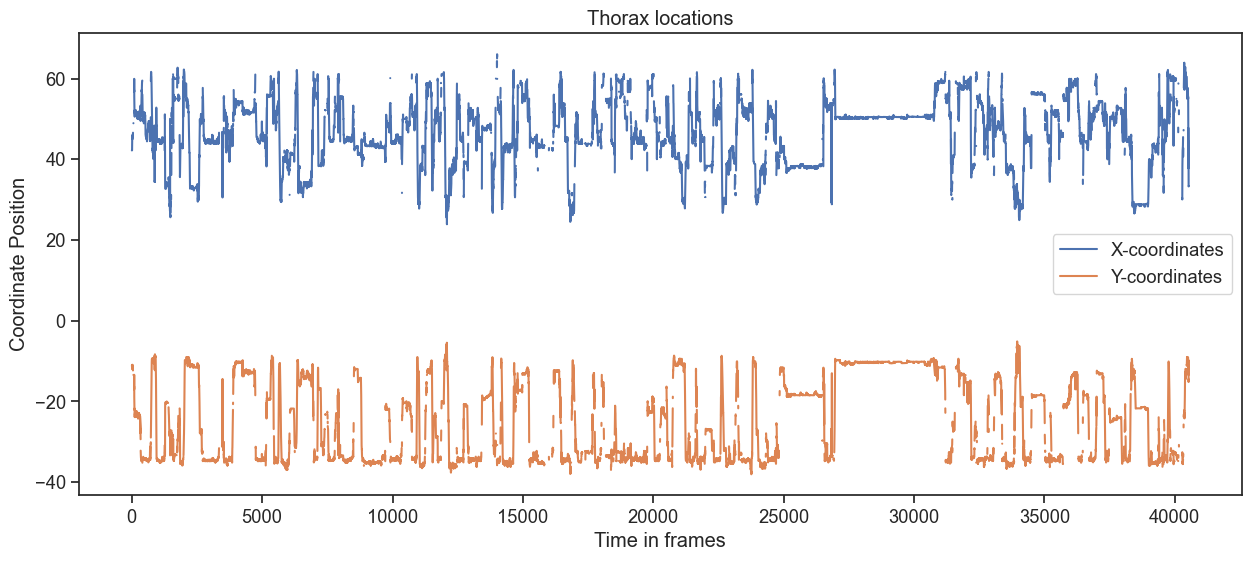

In [67]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

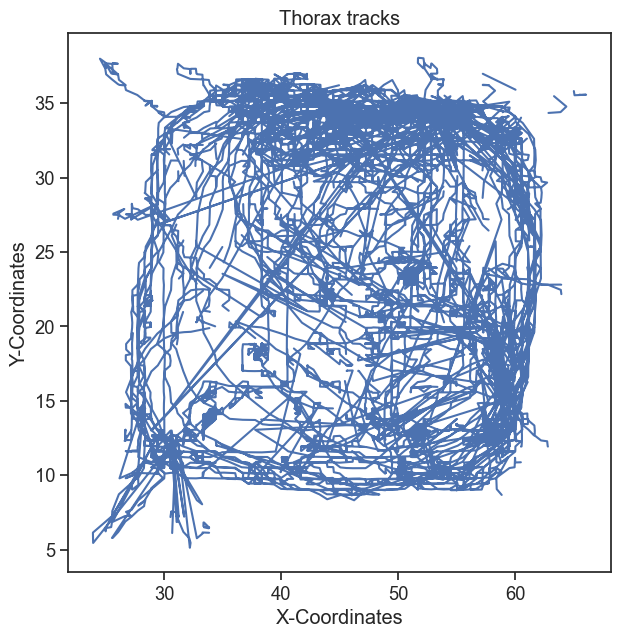

In [68]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


In [69]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[0].shape

(79051, 6, 2)

In [70]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].apply(lambda x: fill_missing(x))

In [71]:
locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX]


In [72]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

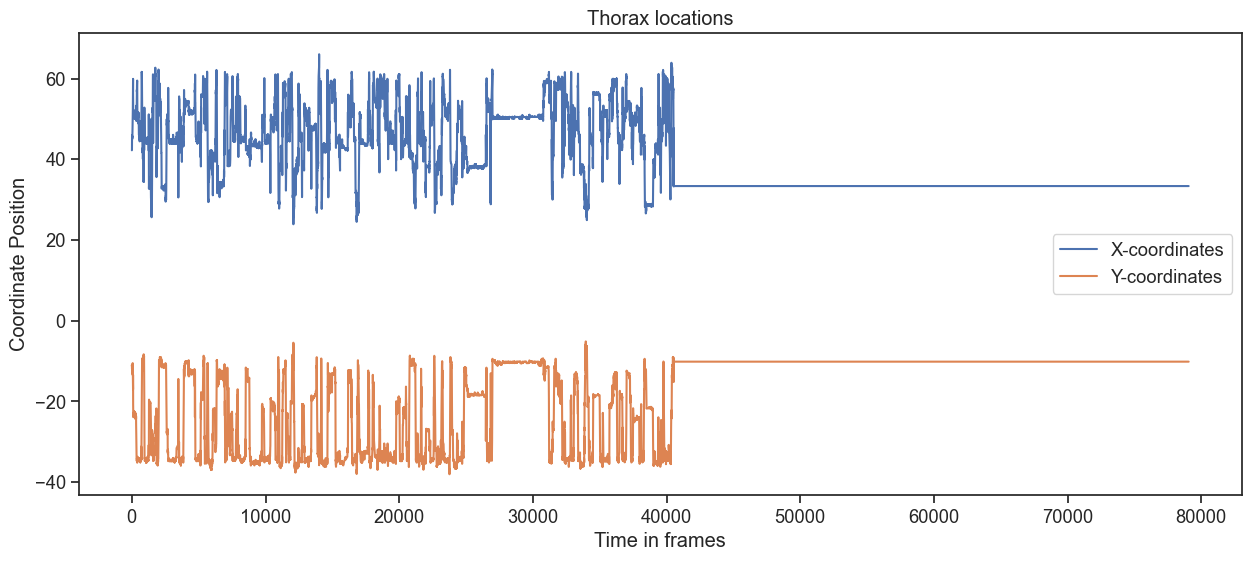

In [73]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

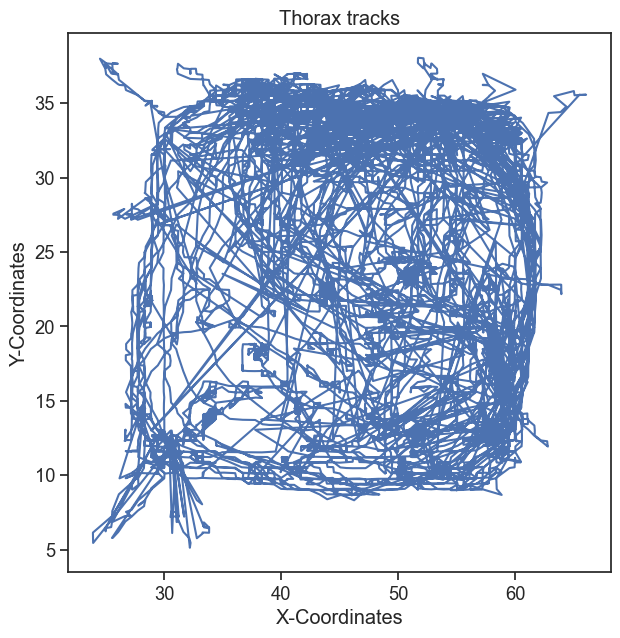

In [74]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


# Creating a histogram of all the velocities for each trial type

In [75]:
TONE_TIMESTAMP_DF["current_subject"] = TONE_TIMESTAMP_DF["current_subject"].astype(str)

In [76]:
merged_trials_and_video = TONE_TIMESTAMP_DF.merge(VIDEO_TO_FRAME_AND_SUBJECT_DF, left_on=['video_name', 'current_subject'], right_on=['video_name', 'subject_id'], how="inner")


In [77]:
merged_trials_and_video.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'all_sleap_data', 'locations', 'track_names',
       'subject_to_index', 'subject_id', 'subject_locations', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_rati

In [78]:
merged_trials_and_video.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,1030879,20230617_115521_standard_comp_to_omission_D1_s...,1029,1.0,1-1_t1b3L_box1,lose_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,264.959511,212.446672,0.138858,0.09058,"[[[40.039741738777444, 9.47029992556593], [42....","[29.623370221193532, 10.85380707317621]","[4.1976991500869625, 3.133946638870072]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
1,4509412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,1030879,20230617_115521_standard_comp_to_omission_D1_s...,1029,1.0,1-1_t1b3L_box1,lose_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,264.959511,212.446672,0.138858,0.09058,"[[[57.86163468579171, 31.554562356382696], [59...","[29.623370221193532, 10.85380707317621]","[4.1976991500869625, 3.133946638870072]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
2,6909411,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,3430878,20230617_115521_standard_comp_to_omission_D1_s...,3425,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,264.959511,212.446672,0.138858,0.09058,"[[[40.039741738777444, 9.47029992556593], [42....","[29.623370221193532, 10.85380707317621]","[4.1976991500869625, 3.133946638870072]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
3,6909411,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,3430878,20230617_115521_standard_comp_to_omission_D1_s...,3425,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,264.959511,212.446672,0.138858,0.09058,"[[[57.86163468579171, 31.554562356382696], [59...","[29.623370221193532, 10.85380707317621]","[4.1976991500869625, 3.133946638870072]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
4,9209413,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,5730880,20230617_115521_standard_comp_to_omission_D1_s...,5720,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,264.959511,212.446672,0.138858,0.09058,"[[[40.039741738777444, 9.47029992556593], [42....","[29.623370221193532, 10.85380707317621]","[4.1976991500869625, 3.133946638870072]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"


In [79]:
merged_trials_and_video["subject_id"]

0      1.1
1      1.1
2      1.1
3      1.1
4      1.1
      ... 
467    1.4
468    1.4
469    1.4
470    1.4
471    1.4
Name: subject_id, Length: 472, dtype: object

In [80]:
merged_trials_and_video["current_subject"]

0      1.1
1      1.1
2      1.1
3      1.1
4      1.1
      ... 
467    1.4
468    1.4
469    1.4
470    1.4
471    1.4
Name: current_subject, Length: 472, dtype: object

In [81]:
merged_trials_and_video["video_frame"]

0       1029
1       1029
2       3425
3       3425
4       5720
       ...  
467    65550
468    67447
469    67447
470    68444
471    68444
Name: video_frame, Length: 472, dtype: int64

In [82]:
merged_trials_and_video["rescaled_locations"].iloc[0].shape

(79051, 6, 2)

- Filtering for all the trial video combinations where the subject is in the given trial

In [83]:
merged_trials_and_video["start_frame"].head()

0    41000
1        0
2    41000
3        0
4    41000
Name: start_frame, dtype: int64

In [84]:
merged_trials_and_video = merged_trials_and_video[(merged_trials_and_video["video_frame"] >= merged_trials_and_video['start_frame']) & (merged_trials_and_video["video_frame"] <= merged_trials_and_video['stop_frame'])].reset_index(drop=True)

In [85]:
merged_trials_and_video.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'all_sleap_data', 'locations', 'track_names',
       'subject_to_index', 'subject_id', 'subject_locations', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_rati

## Calculate Velocity

In [86]:
merged_trials_and_video["all_thorax_locations"] = merged_trials_and_video.apply(lambda x: x["rescaled_locations"][:, THORAX_INDEX, :], axis=1)

In [87]:
merged_trials_and_video["all_thorax_locations"].iloc[0]

array([[59.99533213, 33.3530434 ],
       [60.50075747, 33.33426566],
       [60.53709931, 32.9257053 ],
       ...,
       [36.52993185, 15.9154951 ],
       [36.52993185, 15.9154951 ],
       [36.52993185, 15.9154951 ]])

- Smoothing out the thorax locations

- Calculating the velocity

In [88]:
merged_trials_and_video["all_thorax_velocity"] = merged_trials_and_video["all_thorax_locations"].apply(lambda x: compute_velocity(x, window_size=FRAME_RATE*3) * FRAME_RATE)

- Getting the slice of the velocity for the baseline and trial portion of the recording

In [89]:
merged_trials_and_video["baseline_thorax_velocity"] = merged_trials_and_video.apply(lambda x: x["all_thorax_velocity"][x["baseline_videoframe_range"][0]:x["baseline_videoframe_range"][1]], axis=1)

In [90]:
merged_trials_and_video["trial_thorax_velocity"] = merged_trials_and_video.apply(lambda x: x["all_thorax_velocity"][x["trial_videoframe_range"][0]:x["trial_videoframe_range"][1]], axis=1)

- Getting the average velocity of each 1 sec segment

In [91]:
merged_trials_and_video["trial_chunked_thorax_velocity"] = merged_trials_and_video["trial_thorax_velocity"].apply(lambda x: (chunked_average(x, FRAME_RATE)))

In [92]:
merged_trials_and_video["baseline_chunked_thorax_velocity"] = merged_trials_and_video["baseline_thorax_velocity"].apply(lambda x: (chunked_average(x, FRAME_RATE)))

In [93]:
merged_trials_and_video["baseline_chunked_thorax_velocity"].iloc[0]

array([ 1.04820432,  0.31708611,  0.36975893,  1.05341293,  0.89452508,
        0.81707575,  1.4961133 , 14.06557435, 17.11412316,  8.51801273])

- Getting the time stampes of each 1 sec segment

In [94]:
merged_trials_and_video["trial_chunked_ephys_timestamp"] = merged_trials_and_video["time_stamp_index"].apply(lambda x: [(x +  SPIKEGADGETS_SAMPLE_RATE * num, x + (SPIKEGADGETS_SAMPLE_RATE * (num + 1))) for num in range(TRIAL_DURATION)])

In [95]:
merged_trials_and_video["baseline_chunked_ephys_timestamp"] = merged_trials_and_video["time_stamp_index"].apply(lambda x: [(x +  SPIKEGADGETS_SAMPLE_RATE * num, x + (SPIKEGADGETS_SAMPLE_RATE * (num + 1))) for num in range(-TRIAL_DURATION,0)])

In [96]:
merged_trials_and_video["trial_chunked_lfp_index"] = merged_trials_and_video["lfp_index"].apply(lambda x: [(x +  LFP_SAMPLE_RATE * num, x + (LFP_SAMPLE_RATE * (num + 1))) for num in range(TRIAL_DURATION)])

In [97]:
merged_trials_and_video["baseline_chunked_lfp_index"] = merged_trials_and_video["lfp_index"].apply(lambda x: [(x +  LFP_SAMPLE_RATE * num, x + (LFP_SAMPLE_RATE * (num + 1))) for num in range(-TRIAL_DURATION, 0)])

In [98]:
merged_trials_and_video["baseline_chunked_ephys_timestamp"].iloc[0]

[(830879, 850879),
 (850879, 870879),
 (870879, 890879),
 (890879, 910879),
 (910879, 930879),
 (930879, 950879),
 (950879, 970879),
 (970879, 990879),
 (990879, 1010879),
 (1010879, 1030879)]

In [99]:
merged_trials_and_video["trial_chunked_ephys_timestamp"].iloc[0]

[(1030879, 1050879),
 (1050879, 1070879),
 (1070879, 1090879),
 (1090879, 1110879),
 (1110879, 1130879),
 (1130879, 1150879),
 (1150879, 1170879),
 (1170879, 1190879),
 (1190879, 1210879),
 (1210879, 1230879)]

In [100]:
merged_trials_and_video["baseline_chunked_lfp_index"].iloc[0]

[(41543, 42543),
 (42543, 43543),
 (43543, 44543),
 (44543, 45543),
 (45543, 46543),
 (46543, 47543),
 (47543, 48543),
 (48543, 49543),
 (49543, 50543),
 (50543, 51543)]

In [101]:
merged_trials_and_video["trial_chunked_lfp_index"].iloc[0]

[(51543, 52543),
 (52543, 53543),
 (53543, 54543),
 (54543, 55543),
 (55543, 56543),
 (56543, 57543),
 (57543, 58543),
 (58543, 59543),
 (59543, 60543),
 (60543, 61543)]

In [102]:
merged_trials_and_video["binned_baseline_thorax_velocity"] = merged_trials_and_video["baseline_chunked_thorax_velocity"].apply(lambda x: [np.digitize(num, VELOCITY_BINS) for num in x])

In [103]:
merged_trials_and_video["binned_trial_thorax_velocity"] = merged_trials_and_video["trial_chunked_thorax_velocity"].apply(lambda x: [np.digitize(num, VELOCITY_BINS) for num in x])

In [104]:
merged_trials_and_video["binned_baseline_thorax_velocity"].head()

0    [0, 0, 0, 0, 0, 0, 0, 2, 2, 1]
1    [0, 0, 0, 0, 0, 0, 0, 2, 1, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Name: binned_baseline_thorax_velocity, dtype: object

In [105]:
merged_trials_and_video["binned_trial_thorax_velocity"].head()

0    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
1    [0, 0, 2, 2, 0, 0, 0, 0, 0, 0]
2    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 2, 2, 0, 0, 1, 2]
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: binned_trial_thorax_velocity, dtype: object

In [106]:
merged_trials_and_video = merged_trials_and_video.drop(columns=["all_thorax_velocity", "all_thorax_locations", "all_sleap_data", "locations", "subject_locations", "subject_to_index"], errors="ignore")

In [107]:
merged_trials_and_video = merged_trials_and_video.sort_values(by=["recording_file", "video_number", "time"]).reset_index(drop=True)

In [108]:
flat_list = [item for sublist in merged_trials_and_video["binned_baseline_thorax_velocity"] for item in sublist]


In [109]:
Counter(flat_list)

Counter({0: 2074, 1: 227, 2: 99})

In [110]:
flat_list = [item for sublist in merged_trials_and_video["binned_trial_thorax_velocity"] for item in sublist]


In [111]:
Counter(flat_list)

Counter({0: 2133, 1: 186, 2: 81})

# Creating a histogram of all the velocities for each trial type

In [112]:
num_lines = 3

In [113]:
# Generate colors from the "Blues" colormap
losing_colors = cm.Oranges(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
winning_colors = cm.Blues(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
rewarded_colors = cm.Greens(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
omission_colors = cm.Reds(np.linspace(0.5, 1, num_lines))

In [114]:
outcome_to_color = {'lose': "orange",
 'omission': "red",
 'rewarded': "green",
 'win': "blue"}

In [115]:
trial_or_baseline_to_style = {'trial': "-",
 'baseline': "--"}

In [116]:
merged_trials_and_video["baseline_thorax_velocity"]

0      [1.740210085775107, 1.7046357778943324, 1.6492...
1      [0.20814043433428542, 0.22314126629182324, 0.2...
2      [5.587991473689541, 5.787334491104469, 5.97825...
3      [1.5079694415257687, 1.67290847806871, 1.80495...
4      [4.401859801710984, 4.594906485228284, 4.73967...
                             ...                        
235    [0.15083632715470466, 0.2763562562227468, 0.43...
236    [0.26954963853110736, 0.5336390342987469, 0.77...
237    [0.6389643792864463, 0.8216919700151519, 1.130...
238    [0.8140859487059277, 0.7914479897581302, 0.984...
239    [1.9077957886068988, 1.8184625964386179, 1.703...
Name: baseline_thorax_velocity, Length: 240, dtype: object

/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: Futur

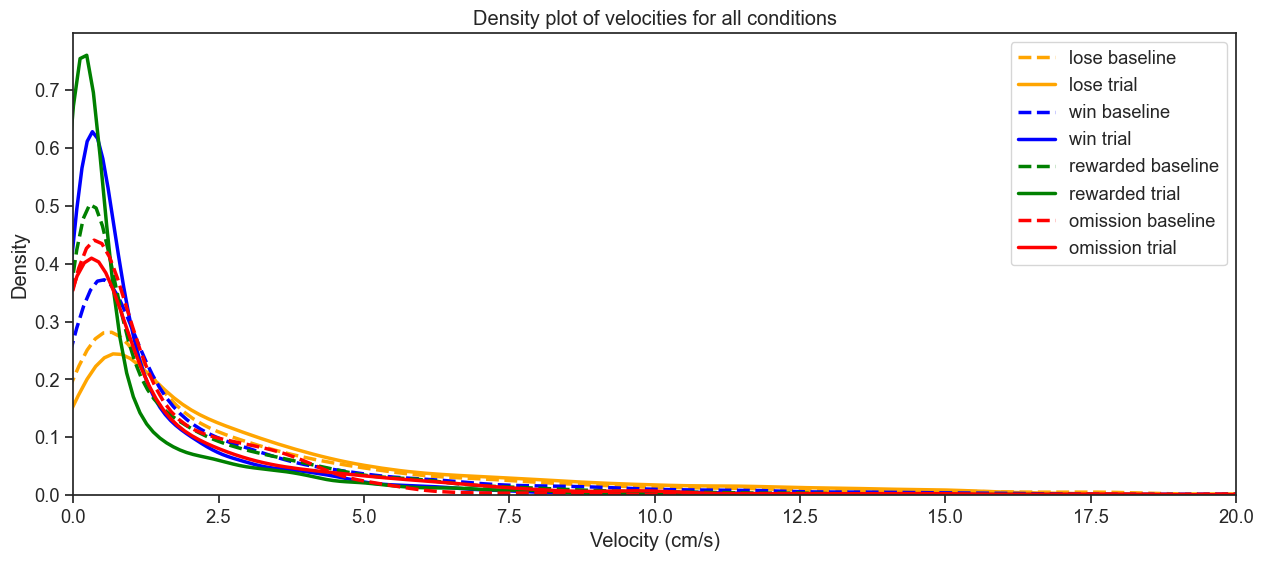

In [117]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in merged_trials_and_video["trial_outcome"].unique():
    current_df = merged_trials_and_video[(merged_trials_and_video["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_thorax_velocity'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"])

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_thorax_velocity'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"])


plt.legend()
plt.title('Density plot of velocities for all conditions'.format(outcome))
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Density')
plt.xlim(0,20)
plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: Futur

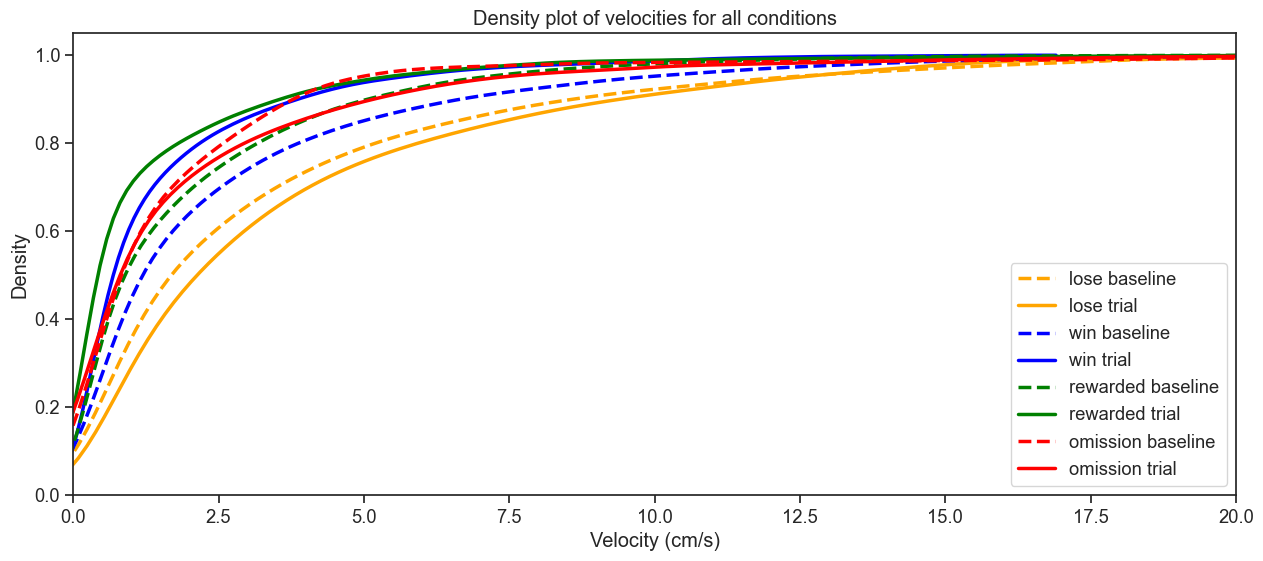

In [118]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in merged_trials_and_video["trial_outcome"].unique():
    current_df = merged_trials_and_video[(merged_trials_and_video["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_thorax_velocity'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"], cumulative=True)

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_thorax_velocity'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"], cumulative=True)


plt.legend()
plt.title('Density plot of velocities for all conditions'.format(outcome))
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Density')
plt.xlim(0,20)
plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

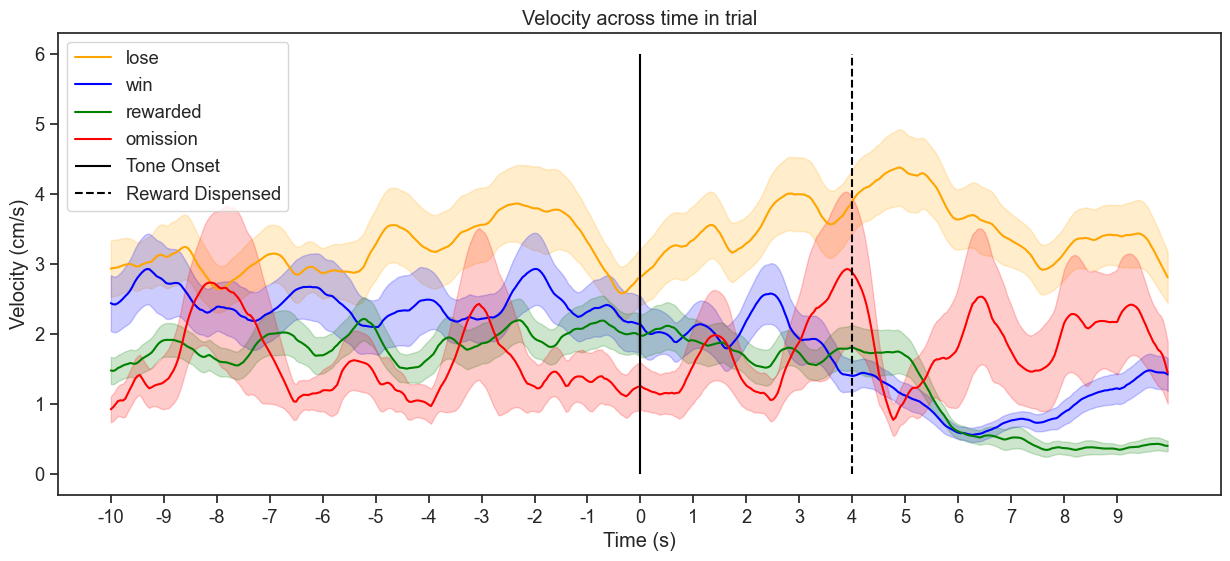

In [119]:
fig, ax = plt.subplots()

for outcome in merged_trials_and_video["trial_outcome"].unique():
    current_df = merged_trials_and_video[(merged_trials_and_video["trial_outcome"] == outcome)]

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_thorax_velocity'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label=outcome, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_thorax_velocity'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

# Making new ticks that are divisible by 10
x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
plt.xticks(x_ticks_range)
# Converting the x ticks into seconds
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
ax.set_xticklabels(new_labels)
plt.vlines(x=0*FRAME_RATE, ymin=0, ymax=6, label="Tone Onset", colors="black")
plt.vlines(x=4*FRAME_RATE, ymin=0, ymax=6, label="Reward Dispensed", colors="black", linestyles="--")


plt.title("Velocity across time in trial")
plt.xlabel("Time (s)")
plt.ylabel('Velocity (cm/s)')

plt.legend(loc="upper left")
plt.savefig("./proc/all_outcome_velocity_across_trial.png")
plt.show()

In [120]:
merged_trials_and_video.to_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [121]:
merged_trials_and_video["recording_file"].unique()

array(['20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)